In [ ]:

from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd

# Initialize Spark session
spark = SparkSession.builder.appName("MNIST_KMeans").getOrCreate()

# Load MNIST data
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
X = X / 255.0  # Normalize pixel values

# Sample 10,000 points to avoid memory issues
data = [(int(label), Vectors.dense(features)) for features, label in zip(X[:10000], y[:10000])]
df = spark.createDataFrame(data, ["label", "features"])


In [ ]:
# Perform KMeans clustering on raw features
kmeans = KMeans(k=15, seed=42, featuresCol="features", predictionCol="cluster")
model = kmeans.fit(df)  # This is the first action that triggers execution
df_clustered = model.transform(df)

# Show cluster distribution
df_clustered.groupBy("cluster").count().show()

# Show relationship between cluster and true label
df_clustered.groupBy("cluster", "label").count().orderBy("cluster", "count", ascending=False).show()


+-------+-----+
|cluster|count|
+-------+-----+
|     12|  592|
|      1|  682|
|     13|  703|
|      6|  686|
|      3|  623|
|      5|  530|
|      9|  705|
|      4|  378|
|      8|  437|
|      7|  788|
|     10|  870|
|     11|  798|
|     14|  614|
|      2|  443|
|      0| 1151|
+-------+-----+

+-------+-----+-----+
|cluster|label|count|
+-------+-----+-----+
|     14|    6|  532|
|     14|    0|   32|
|     14|    5|   17|
|     14|    2|   13|
|     14|    4|    7|
|     14|    8|    6|
|     14|    3|    5|
|     14|    9|    2|
|     13|    2|  663|
|     13|    3|   25|
|     13|    8|    6|
|     13|    7|    3|
|     13|    6|    2|
|     13|    4|    2|
|     13|    1|    2|
|     12|    4|  305|
|     12|    9|  173|
|     12|    7|   43|
|     12|    8|   26|
|     12|    5|   19|
+-------+-----+-----+
only showing top 20 rows



In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors
from sklearn.datasets import fetch_openml
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd

# Start Spark session
spark = SparkSession.builder.appName("MNIST-KMeans-Silhouette-OneK").getOrCreate()

# Load and normalize MNIST
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
X = X / 255.0

# Sample 10,000 rows
X_sample = X[:10000]
data = [(Vectors.dense(row),) for row in X_sample]
df = spark.createDataFrame(data, ["features"]).cache()

# Set a single value of k
k = 15

# Fit KMeans
kmeans = KMeans(k=k, seed=42, featuresCol="features", predictionCol="cluster")
model = kmeans.fit(df)
clustered = model.transform(df).select("features", "cluster")

# Convert to Pandas and compute Silhouette Score
pd_clustered = clustered.toPandas()
features_np = np.array([x.toArray() for x in pd_clustered["features"]])
labels_np = pd_clustered["cluster"].to_numpy()

score = silhouette_score(features_np, labels_np)
print(f"Silhouette Score for k={k} → {score:.4f}")




Silhouette Score for k=15 → 0.0636


Running t-SNE for 2D visualization...


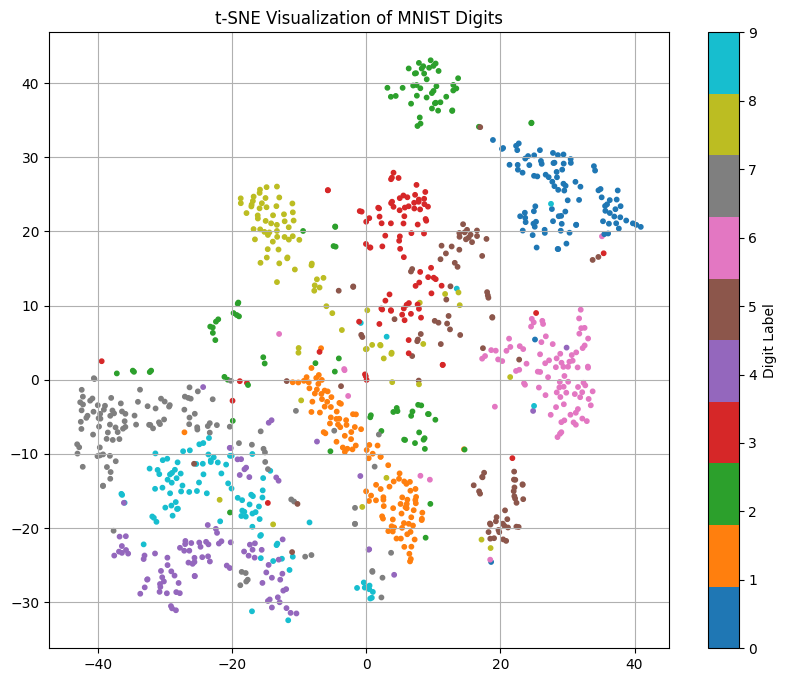

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Step 1: Load data
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
X = X / 255.0  # Normalize

# Step 2: Take a small sample for t-SNE (it's slow!)
X_vis = X[:1000]
y_vis = y[:1000]

# Step 3: Run t-SNE
print("Running t-SNE for 2D visualization...")
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto', perplexity=30)
X_2d = tsne.fit_transform(X_vis)

# Step 4: Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_vis.astype(int), cmap='tab10', s=10)
plt.colorbar(scatter, ticks=range(10), label="Digit Label")
plt.title("t-SNE Visualization of MNIST Digits")
plt.grid(True)
plt.show()


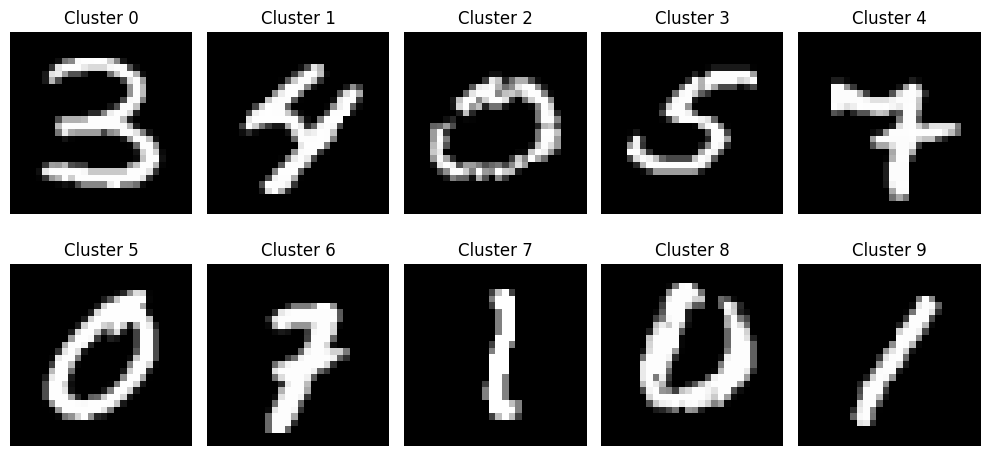

In [ ]:
# Show 1 image per cluster
import matplotlib.pyplot as plt

# Convert clustered data to Pandas
df_img = df_clustered.select("cluster", "features").sample(fraction=0.01).toPandas()
df_img["features"] = df_img["features"].apply(lambda x: np.array(x))

# Plot one image per cluster
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    ax = axes[i//5, i%5]
    img = df_img[df_img["cluster"] == i]["features"].values[0].reshape(28, 28)
    ax.imshow(img, cmap="gray")
    ax.set_title(f"Cluster {i}")
    ax.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
# Show current number of partitions
print(f"Original number of partitions: {df.rdd.getNumPartitions()}")

# Repartition into 4 for parallel task distribution
df = df.repartition(4)
print(f"Repartitioned to: {df.rdd.getNumPartitions()} partitions")

# Show how data is distributed among partitions
def show_partition_data(index, iterator):
    yield f"Partition {index} has {len(list(iterator))} records"

for line in df.rdd.mapPartitionsWithIndex(show_partition_data).collect():
    print(line)


Original number of partitions: 2
Repartitioned to: 4 partitions
Partition 0 has 2500 records
Partition 1 has 2500 records
Partition 2 has 2500 records
Partition 3 has 2500 records


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from sklearn.datasets import fetch_openml
import numpy as np

# Step 1: Start Spark session
spark = SparkSession.builder \
    .appName("MNIST Lazy Evaluation") \
    .getOrCreate()

# Step 2: Load MNIST (only 10,000 samples for speed)
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
X = X[:10000] / 255.0  # Normalize pixel values
y = y[:10000]

# Step 3: Convert to Spark DataFrame
data = [(int(label), Vectors.dense(features)) for features, label in zip(X, y)]
df = spark.createDataFrame(data, ["label", "features"])

# Step 4: Apply Lazy Transformations
mapped_rdd = df.rdd.map(lambda row: (row['label'], float(np.sum(row['features']))))
filtered_rdd = mapped_rdd.filter(lambda x: x[1] > 100)

print("Lazy transformations applied: map + filter — but Spark has NOT executed yet!")

# Step 5: Trigger Action → Now Spark runs the DAG
print("⚡ Triggering action using .take(5):")
print(filtered_rdd.take(5))  # <-- This line causes execution

# Optional: Another action to show repeated lazy evaluation
print("⚡ Count of rows with pixel sum > 100:")
print(filtered_rdd.count())  # <-- Executes again unless cached




Lazy transformations applied: map + filter — but Spark has NOT executed yet!
⚡ Triggering action using .take(5):
[(5, 107.94117647058823), (0, 121.94117647058823), (2, 116.08235294117647), (3, 140.65490196078431), (3, 111.95294117647059)]
⚡ Count of rows with pixel sum > 100:
4981


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
from sklearn.datasets import fetch_openml
import os

# Create Spark session
spark = SparkSession.builder.appName("FaultToleranceExample").getOrCreate()

# Set checkpoint directory (needed for lineage cutting)
spark.sparkContext.setCheckpointDir("/tmp/spark_checkpoints")

# Load MNIST dataset
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
X = X / 255.0

# Take only 5000 rows for speed
X_sample = X[:5000]
data = [(Vectors.dense(row),) for row in X_sample]
df = spark.createDataFrame(data, ["features"])

# Optional: Cache and checkpoint for fault tolerance
df.cache()
df = df.checkpoint(eager=True)  # Cuts lineage to reduce recomputation cost

try:
    # Simulate computation
    kmeans = KMeans(k=10, seed=42, featuresCol="features", predictionCol="cluster")
    model = kmeans.fit(df)
    clustered = model.transform(df)

    # Count records in each cluster (action triggers execution)
    clustered.groupBy("cluster").count().show()

except Exception as e:
    print("⚠️ Fault occurred during KMeans or transformation.")#DAG (history is maintained graph)
    print("Error message:", e)
    print("Retrying computation...")

    # Retry logic (rerun if fault occurs)
    model = kmeans.fit(df)
    clustered = model.transform(df)
    clustered.groupBy("cluster").count().show()



+-------+-----+
|cluster|count|
+-------+-----+
|      1|  636|
|      6|  865|
|      3|  408|
|      5|  528|
|      9|  394|
|      4|  455|
|      8|  361|
|      7|  355|
|      2|  435|
|      0|  563|
+-------+-----+

